

##Install the packages


In [ ]:
!pip install open3d==0.16.0      # Install version 16
!pip install pypotree   # colab/jupyter version of potree(library for plotting pointclouds)

##Importing the required libraries

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import open3d as o3d
import pypotree
import glob  # glob(short for global) is used to search for files that match a specific pattern or name, for e.g. CSV Files


## Download the Data Files

In [4]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/visual-fusion-mini-course/data.zip
!unzip -qq data.zip
!mkdir output_data

--2023-12-05 06:15:15--  https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/visual-fusion-mini-course/data.zip
Resolving pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)... 52.92.240.122, 3.5.83.186, 3.5.82.161, ...
Connecting to pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)|52.92.240.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182263225 (174M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 173.82M  42.7MB/s    in 4.3s    

2023-12-05 06:15:20 (40.5 MB/s) - ‘data.zip’ saved [182263225/182263225]



##Reading the data files

In [12]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))


##Visualizing the Image and Point Clouds

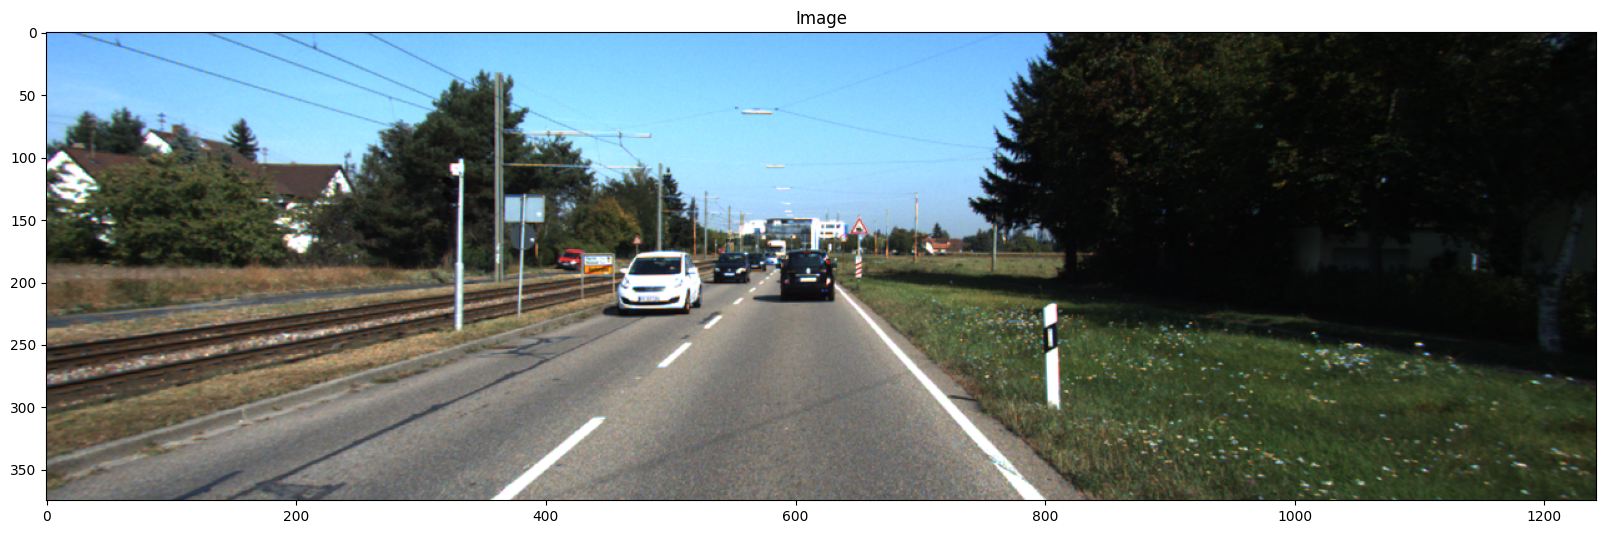

In [13]:
# Visualizing Image

index = 3    # Visualize Image number 1

image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,1, figsize= (20,10))
ax.imshow(image)
ax.set_title('Image');


In [14]:
#Visualizing Point Cloud

pcd_file = point_files[index]

point_cloud = o3d.io.read_point_cloud(pcd_file)    #Read point cloud from the pcd file

points = np.asarray(point_cloud.points)

cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)


/usr/local/lib/python3.10/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p 488706 --material ELEVATION --edl-enabled --overwrite
https://localhost:46869/point_clouds/pointclouds/488706


## Lidar Point Cloud Fusion with the Images

In [16]:
class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        P = calibs["P2"]
        self.P = np.reshape(P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        R0 = calibs["R0_rect"]
        self.R0 = np.reshape(R0, [3, 3])

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

    def cart2hom(self, pts_3d):
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    def project_velo_to_image(self, pts_3d_velo):

        # REVERSE TECHNIQUE
        '''
        homogeneous = self.cart2hom(pts_3d_velo)  # nx4
        dotted_RT = np.dot(homogeneous, np.transpose(self.V2C)) #nx3
        dotted_with_RO = np.transpose(np.dot(self.R0, np.transpose(dotted_RT))) #nx3
        homogeneous_2 = self.cart2hom(dotted_with_RO) #nx4
        pts_2d = np.dot(homogeneous_2, np.transpose(self.P))  # nx3
        '''

        # NORMAL TECHNIQUE
        R0_homo = np.vstack([self.R0, [0, 0, 0]])
        R0_homo_2 = np.column_stack([R0_homo, [0, 0, 0, 1]])
        p_r0 = np.dot(self.P, R0_homo_2) #PxR0
        p_r0_rt =  np.dot(p_r0, np.vstack((self.V2C, [0, 0, 0, 1]))) #PxROxRT
        pts_3d_homo = np.column_stack([pts_3d_velo, np.ones((pts_3d_velo.shape[0],1))])
        p_r0_rt_x = np.dot(p_r0_rt, np.transpose(pts_3d_homo))#PxROxRTxX
        pts_2d = np.transpose(p_r0_rt_x)

        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
        pts_2d = self.project_velo_to_image(pc_velo)
        fov_inds = (
            (pts_2d[:, 0] < xmax)
            & (pts_2d[:, 0] >= xmin)
            & (pts_2d[:, 1] < ymax)
            & (pts_2d[:, 1] >= ymin)
        )
        fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance) # We don't want things that are closer to the clip distance (2m)
        imgfov_pc_velo = pc_velo[fov_inds, :]
        if return_more:
            return imgfov_pc_velo, pts_2d, fov_inds
        else:
            return imgfov_pc_velo

    def show_lidar_on_image(self, pc_velo, img, debug="False"):
        imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
            pc_velo, 0, 0, img.shape[1], img.shape[0], True
        )
        if (debug==True):
            print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
            print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
            print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
        self.imgfov_pts_2d = pts_2d[fov_inds, :]

        '''
        #homogeneous = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
        homogeneous = self.cart2hom(imgfov_pc_velo)
        transposed_RT = np.dot(homogeneous, np.transpose(self.V2C))
        dotted_RO = np.transpose(np.dot(self.R0, np.transpose(transposed_RT)))
        self.imgfov_pc_rect = dotted_RO

        if debug==True:
            print("FOV PC Rect "+ str(self.imgfov_pc_rect))
        '''
        cmap = plt.cm.get_cmap("hsv", 256)
        cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
        self.imgfov_pc_velo = imgfov_pc_velo

        for i in range(self.imgfov_pts_2d.shape[0]):
            #depth = self.imgfov_pc_rect[i,2]
            #print(depth)
            depth = imgfov_pc_velo[i,0]
            #print(depth)
            color = cmap[int( 510.0 / depth), :]
            cv2.circle(
                img,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,
                color=tuple(color),
                thickness=-1,
            )

        return img

##Testing the Fusion Code on 1 Image

<ipython-input-16-903508af315c>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


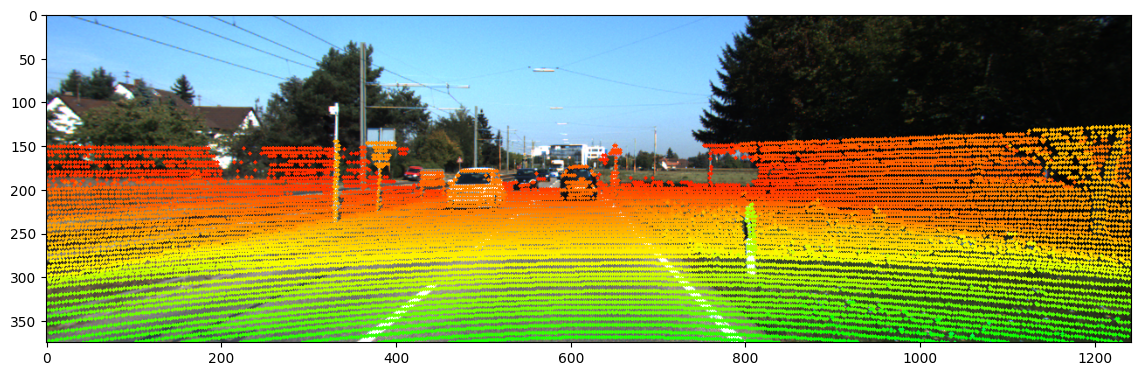

In [17]:
lidar2cam = LiDAR2Camera(calib_files[index])
img = image.copy()
img = lidar2cam.show_lidar_on_image(points[:,:3], img)
plt.figure(figsize=(14,7))
plt.imshow(img)
plt.show()



## Saving the Output Video

In [19]:
video_images = sorted(glob.glob("data/video/images/*.png"))
video_points = sorted(glob.glob("data/video/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.show_lidar_on_image(point_cloud, image))

out = cv2.VideoWriter('output_data/out.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (image.shape[1],image.shape[0]))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()

<ipython-input-16-903508af315c>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
